In [25]:
import pandas as pd
from surprise import Dataset, Reader, SVD, SVDpp
from surprise.accuracy import rmse
from surprise import KNNBasic
from matplotlib import pyplot as plt
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
from scipy import stats

In [2]:
user,item,title = 'userId','movieId','title'


In [3]:
cols = ['User ID','Movie ID','Rating','Timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', delimiter='\t', 
                         header=None, names=[user,item,'rating','timestamp'])
ratings_df[:3]

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [4]:
movies = pd.read_csv('ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None, 
                     names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies[:3]

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
rating_movie = ratings_df.merge(movies[[item, title]])
rating_movie = rating_movie[['userId', 'movieId', 'rating', 'title']]
rating_movie[:3]

,userId,movieId,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)


In [20]:
def coverage_and_diversity(test_predictions, N=10):
    test_predictions_tuples = [pred[:4] for pred in test_predictions]
    test_pred_df = pd.DataFrame(test_predictions_tuples,
                                columns=['uid', 'iid', 'r_ui', 'est'])
    highest_est_per_user = []

    for uid in range(1, 944):
        highest_est_per_user.append(
            list(
                map(
                    lambda e: e[0],
                    sorted(test_pred_df.loc[test_pred_df['uid'] == str(uid)][[
                        'iid', 'est'
                    ]].values,
                           key=lambda e: e[1],
                           reverse=True)[:N])))
    unique, counts = np.unique(highest_est_per_user, return_counts=True)
    coverage = len(unique) / 1682
    X = np.zeros(1682)
    X[np.array(list(map(int, unique)))] = counts/N
    plt.figure(figsize=(15, 5))
    plt.plot(X)
    plt.show()
    return coverage

In [6]:
ml_100k = Dataset.load_builtin(name=u'ml-100k', prompt=True)

In [15]:
trainset, testset = train_test_split(ml_100k, test_size=.35)


In [17]:
cf = KNNBasic()
cf.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [18]:
predictions = cf.test(testset)

In [19]:
MSE = accuracy.mse(predictions)
MAE = accuracy.mae(predictions)
RMSE = accuracy.rmse(predictions)

MSE: 0.9768
MAE:  0.7814
RMSE: 0.9883


In [22]:
coverage_testset = [
    (str(i), str(j), '0.0') for i in range(1, 944) for j in range(1, 1683)
]

In [23]:
coverage_predictions = cf.test(coverage_testset)


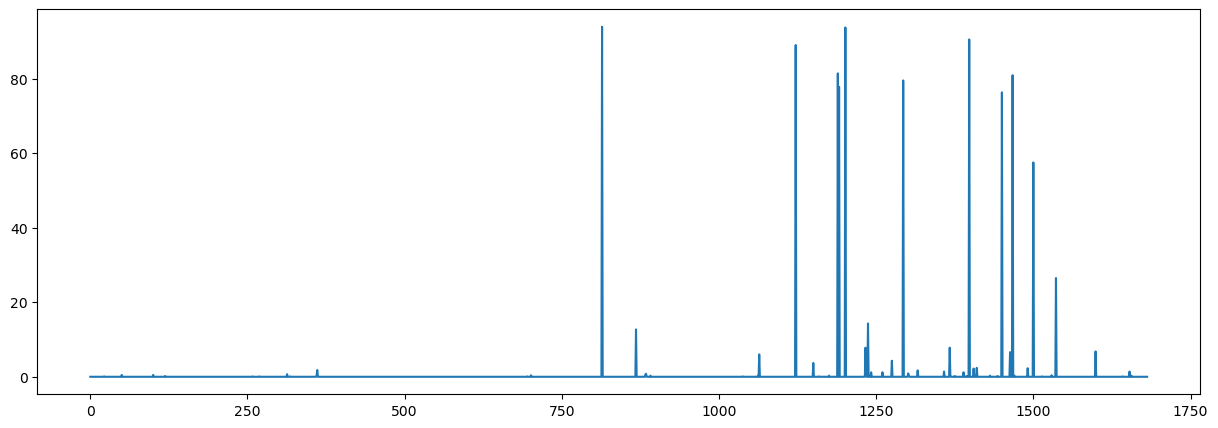

0.03626634958382877

In [26]:
coverage_and_diversity(coverage_predictions)

### B) SVD and SVD++

In [27]:
trainset, testset = train_test_split(ml_100k, test_size=0.25)
algo = SVD()
algo.fit(trainset)

In [28]:
predictions = algo.test(testset)
svd_MSE = accuracy.mse(predictions)
svd_MAE = accuracy.mae(predictions)
svd_RMSE = accuracy.rmse(predictions)

MSE: 0.8860
MAE:  0.7412
RMSE: 0.9413


In [29]:
coverage_testset = [
    (str(i), str(j), '0.0') for i in range(1, 944) for j in range(1, 1683)
]

In [30]:
coverage_predictions = cf.test(coverage_testset)

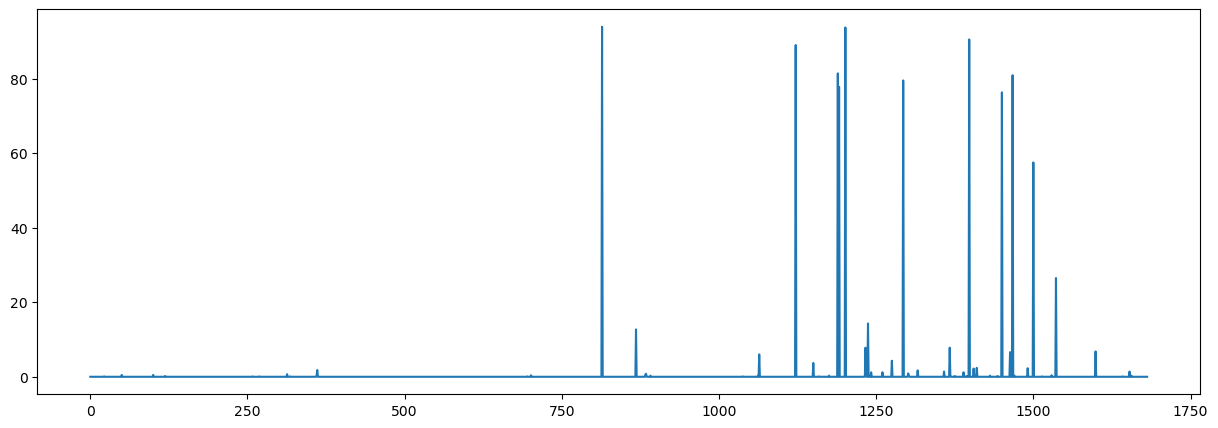

0.03626634958382877

In [33]:
coverage_and_diversity(coverage_predictions)

#### SVD++

In [9]:
cf = SVDpp()
cf.fit(trainset)
predictions = cf.test(testset)

In [10]:
svdpp_MSE = accuracy.mse(predictions)
svdpp_MAE = accuracy.mae(predictions)
svdpp_RMSE = accuracy.rmse(predictions)

MSE: 0.8472
MAE:  0.7239
RMSE: 0.9205


### C)

Temporal dynamics: Recommendation systems often have temporal dynamics, where the performance of algorithms can change over time. Cross-validation may not adequately capture these dynamics since it randomly shuffles the data without considering the temporal aspect.\
and also recommendation datasets are typically sparse, with many missing ratings or interactions. Cross-validation may inadvertently hide the true sparsity of the data and lead to over-optimistic performance estimates.



### D) compare recommentation accuracy for experienced and less active users 

In [11]:
reader = Reader(rating_scale=(1, 5))
dataset = ml_100k.build_full_trainset().build_testset()

In [12]:
experienced_users = set()
less_active_users = set()
user_ratings_count = {}

for uid, _, _ in dataset:
    if uid not in user_ratings_count:
        user_ratings_count[uid] = 0
    user_ratings_count[uid] += 1

for uid, count in user_ratings_count.items():
    if count >= 100:  # Define a threshold for experienced users
        experienced_users.add(uid)
    else:
        less_active_users.add(uid)

In [13]:

experienced_data = [(uid, iid, rating) for (uid, iid, rating) in dataset if uid in experienced_users]
less_active_data = [(uid, iid, rating) for (uid, iid, rating) in dataset if uid in less_active_users]

experienced_trainset = ml_100k.build_full_trainset()
experienced_testset = [(uid, iid, rating) for (uid, iid, rating) in dataset if uid in experienced_users]

less_active_trainset = ml_100k.build_full_trainset()
less_active_testset = [(uid, iid, rating) for (uid, iid, rating) in dataset if uid in less_active_users]

svd_experienced = SVDpp()
svd_less_active = SVDpp()

svd_experienced.fit(experienced_trainset)
svd_less_active.fit(less_active_trainset)

experienced_predictions = svd_experienced.test(experienced_testset)
less_active_predictions = svd_less_active.test(less_active_testset)

In [14]:
experienced_rmse = rmse(experienced_predictions)
less_active_rmse = rmse(less_active_predictions)

print("Experienced Users (RMSE):", experienced_rmse)
print("Less Active Users (RMSE):", less_active_rmse)


RMSE: 0.7450
RMSE: 0.7940
Experienced Users (RMSE): 0.745032843045073
Less Active Users (RMSE): 0.7939633483440127
